In [2]:
import os
import pandas as pd 
import numpy as np

In [3]:
data_dir = 'Data/CSV'
dataframes = []
for file_name in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file_name)
    target = file_name[:-4] # remove ".csv"
    taget = target.split('_')[0] 

    df = pd.read_csv(file_path)
    df.fillna(0, inplace=True)
    df['target'] = target
    dataframes.append(df)
    
    print(f"Number of {target}: " + str(df.shape[0]))

data = pd.concat(dataframes)

Number of bruteforce: 14501
Number of slowite: 9202
Number of flood: 613


/var/folders/yv/rl10xyh574v0pblkn8707bzr0000gn/T/ipykernel_60898/1972987587.py:8: DtypeWarning: Columns (21,23,34,39,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Number of legitimate_1w: 11915716
Number of malformed: 10924


/var/folders/yv/rl10xyh574v0pblkn8707bzr0000gn/T/ipykernel_60898/1972987587.py:8: DtypeWarning: Columns (21,23,34,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Number of malaria: 130223


# Distribution

<AxesSubplot: >

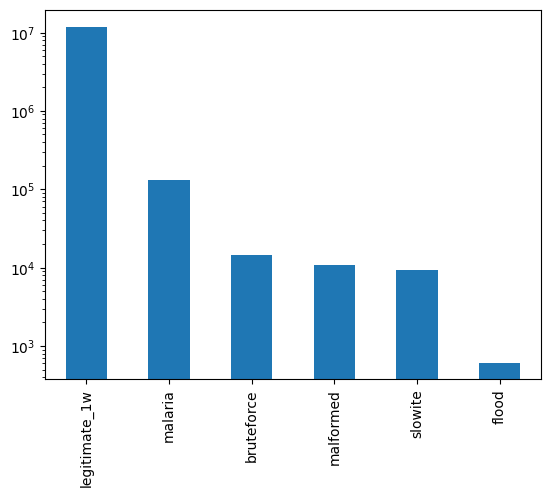

In [4]:
data['target'].value_counts().plot(kind='bar',logy=True)

In [22]:
print(data.dtypes.to_string())

frame.time_delta              float64
frame.time_delta_displayed    float64
frame.time_epoch              float64
frame.time_invalid            float64
frame.time_relative           float64
eth.src                        object
eth.dst                        object
ip.src                         object
ip.dst                         object
tcp.srcport                     int64
tcp.dstport                     int64
tcp.flags                      object
frame.cap_len                   int64
frame.len                       int64
frame.number                    int64
tcp.stream                      int64
tcp.analysis.initial_rtt      float64
tcp.time_delta                float64
tcp.len                         int64
tcp.window_size_value           int64
tcp.checksum                   object
mqtt.clientid                  object
mqtt.clientid_len             float64
mqtt.conack.flags              object
mqtt.conack.flags.reserved    float64
mqtt.conack.flags.sp          float64
mqtt.conack.

# Drop Useless Columns

In [57]:
data['ip.proto'].value_counts()

6    12081179
Name: ip.proto, dtype: int64

In [58]:
# columns with extreme distribution e.g. mostly zeors or null
cols_bad_dist = ['tcp.checksum','mqtt.msg', 'mqtt.topic', 'mqtt.username', 'mqtt.protoname',
            'mqtt.passwd', 'mqtt.conack.flags', 'mqtt.conflags', 'ip.proto']
# columns that are not useful
cols_not_informative = ['eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'mqtt.passwd_len',
            'mqtt.username_len', 'mqtt.clientid']

cols_to_drop = cols_bad_dist + cols_not_informative
data = data.drop(columns=cols_to_drop)

# preprocess feature columns

In [63]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

features_to_encode = []
for col, dtype in data.dtypes.iteritems():
    # skip target 
    if col == 'target':
        continue
    # encode string features
    if str(dtype) == "object":
        print(col, dtype, data[col].unique().shape)
        # null was converted to 0, need to be converted to string for the encoder
        data[col] = data[col].astype(str)
        features_to_encode.append(col)

sub_data = data[features_to_encode]
enc.fit(sub_data)
print(enc.categories_)
data[features_to_encode] = enc.transform(sub_data)


tcp.flags object (8,)
mqtt.hdrflags object (14,)
[array(['0x00000002', '0x00000004', '0x00000010', '0x00000011',
       '0x00000012', '0x00000014', '0x00000018', '0x00000019'],
      dtype=object), array(['0', '0x00000010', '0x00000020', '0x00000030', '0x00000031',
       '0x00000032', '0x0000003a', '0x00000040', '0x00000050',
       '0x00000082', '0x00000090', '0x000000c0', '0x000000d0',
       '0x000000e0'], dtype=object)]


# Encode labels

In [64]:
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()

lenc.fit(data['target'])
print(lenc.classes_)
data['target'] = lenc.transform(data['target'])

['bruteforce' 'flood' 'legitimate_1w' 'malaria' 'malformed' 'slowite']


# Cast feature types

In [66]:
features = data.drop(columns=['target'])
features = features.astype(np.float64)
labels   = data['target']

# Train/Test Split and Save to files

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [82]:
def save_file(df, file_name):
    save_dir = 'Data'
    df.to_csv(os.path.join(save_dir, file_name), index = False, header=True)

X_train['target'] = y_train
save_file(X_train, 'train.csv')

X_test['target'] = y_test
save_file(X_test, 'test.csv')

8371781     1.592380e+09
2702732     1.592092e+09
37679       1.591957e+09
11211625    1.592524e+09
2740733     1.592094e+09
                ...     
816598      1.591996e+09
8747751     1.592399e+09
11367370    1.592532e+09
3806973     1.592148e+09
10200911    1.592473e+09
Name: frame.time_epoch, Length: 3624354, dtype: float64